In [18]:
import pandas as pd
import numpy as np
import pyBigWig as pybw
import os
import h5py
import pyfaidx

In [19]:

tobias_motif_id ="GATA3_GATA_1_GATA3_GATA_1"
#tobias_motif_id = "TYY1_HUMAN.H11MO.0.A_TYY1_HUMAN.H11MO.0.A"
# tobias_motif_id = "CTCF_MA0139.1_CTCF_MA0139.1_1"
#tobias_motif_id="KLF12_HUMAN.H11MO.0.C_KLF12_HUMAN.H11MO.0.C"
chip_enc = "ENCSR257RKC"
#chip_enc = "ENCSR000EWF"
# chip_enc = "ENCSR000EGM"
#chip_enc = "ENCSR372IML"
hit_call_bed_atac = "/mnt/lab_data3/anusri/chrombpnet/results/chrombpnet/ATAC_PE/HEPG2/testing/atlas_runs/benchmarking/og_version_only_cwm_ATAC/"
#atac_motif_id= "0_15"
atac_motif_id= "0_0"
# atac_motif_id="0_1"
#atac_motif_id= "0_2"
hit_call_bed_dnase= "/mnt/lab_data3/anusri/chrombpnet/results/chrombpnet/ATAC_PE/HEPG2/testing/atlas_runs/benchmarking/og_version_only_cwm_DNASE/"
#dnase_motif_id= "0_15"
dnase_motif_id= "0_0"
# dnase_motif_id= "0_1"
#dnase_motif_id= "0_2"
# use arguments to fill paths

finemo_hits_path = "/oak/stanford/groups/akundaje/atwang/finemo_gpu_test/K562/obs_a_0.6_c_0.0005_v5/chip/GATA_raw/hit_importances.bed"

# output_dir = "/mnt/lab_data3/anusri/chrombpnet/results/chrombpnet/ATAC_PE/HEPG2/testing/viveks/og_version_filter_modisco_rank_resolve_benchmark/"
output_dir = "/oak/stanford/groups/akundaje/atwang/finemo_gpu_test/K562/chip/benchmark_GATA/"


motif_hits_path_tobias="/mnt/lab_data2/anusri/chrombpnet/results/tobias/ATAC_PE/K562/K562_ATAC_TOBIAS/"+tobias_motif_id+"/beds/"+tobias_motif_id+"_K562_bound.bed"
chip_seq_bw_path="/oak/stanford/groups/akundaje/vir/tfatlas/shap/production_run_1/fold1/"+chip_enc+"/counts_scores.bw"
chip_seq_bed_path="/oak/stanford/groups/akundaje/vir/tfatlas/shap/production_run_1/fold1/"+chip_enc+"/peaks_valid_scores.bed"
# atac_hits_path=os.path.join(hit_call_bed_atac,"temp/final.bed")
dnase_hits_path=os.path.join(hit_call_bed_dnase,"auxiliary/final.bed")

# observed_atac = "/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/ATAC_PE/K562/data/K562_unstranded.bw"
observed_dnase = "/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/DNASE_PE/K562/data/K562_unstranded.bw"

genome_fasta = "/mnt/lab_data2/anusri/chrombpnet/reference/hg38.genome.fa"

tfmodisco_atac="/oak/stanford/groups/akundaje/projects/chrombpnet_paper_new/modisco_jun_30/modisco/ATAC/K562/modiscolite_crop_500_1M_seqs/modisco_results_allChroms_counts.hdf5"
tfmodisco_dnase="/oak/stanford/groups/akundaje/projects/chrombpnet_paper_new/modisco_jun_30/modisco/DNASE/K562/modiscolite_crop_500_1M_seqs/modisco_results_allChroms_counts.hdf5"


In [20]:
def find_hits_in_peaks(input_hits, chip_bed, output_dir, output_path):
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, output_path)
    #print(output_dir)
    command = []
    command += ["bedtools"]
    command += ["intersect"]
    command += ["-a"]
    command += [input_hits]
    command += ["-b"]
    command += [chip_bed]
    command += ["-wa"]
    command += ["|"]
    command += ["sort"]
    command += ["|"]
    command += ["uniq"]
    command += [">"]
    command += [output_path]
    
    print(" ".join(command))
    os.system(" ".join(command))
    
def dna_to_one_hot(seqs):
    """
    Converts a list of DNA ("ACGT") sequences to one-hot encodings, where the
    position of 1s is ordered alphabetically by "ACGT". `seqs` must be a list
    of N strings, where every string is the same length L. Returns an N x L x 4
    NumPy array of one-hot encodings, in the same order as the input sequences.
    All bases will be converted to upper-case prior to performing the encoding.
    Any bases that are not "ACGT" will be given an encoding of all 0s.
    """
    seq_len = len(seqs[0])
    assert np.all(np.array([len(s) for s in seqs]) == seq_len)

    # Join all sequences together into one long string, all uppercase
    seq_concat = "".join(seqs).upper() + "ACGT"
    # Add one example of each base, so np.unique doesn't miss indices later

    one_hot_map = np.identity(5)[:, :-1].astype(np.int8)

    # Convert string into array of ASCII character codes;
    base_vals = np.frombuffer(bytearray(seq_concat, "utf8"), dtype=np.int8)

    # Anything that's not an A, C, G, or T gets assigned a higher code
    base_vals[~np.isin(base_vals, np.array([65, 67, 71, 84]))] = 85

    # Convert the codes into indices in [0, 4], in ascending order by code
    _, base_inds = np.unique(base_vals, return_inverse=True)

    # Get the one-hot encoding for those indices, and reshape back to separate
    return one_hot_map[base_inds[:-4]].reshape((len(seqs), seq_len, 4))
 
def import_tfmodisco_motifs(tfm_results_path, trim=True, only_pos=True):
    """
    Imports the PFMs to into a dictionary, mapping `(x, y)` to the PFM,
    where `x` is the metacluster index and `y` is the pattern index.
    Arguments:
        `tfm_results_path`: path to HDF5 containing TF-MoDISco results
        `out_dir`: where to save motifs
        `trim`: if True, trim the motif flanks based on information content
        `only_pos`: if True, only return motifs with positive contributions
    Returns the dictionary of PFMs.
    """ 
    
    def softmax(x, temp=100):
        norm_x = x - np.mean(x,axis=1, keepdims=True)
        return np.exp(temp*norm_x)/np.sum(np.exp(temp*norm_x), axis=1, keepdims=True)

    def trim_motif_new(cwm, motif, trim_threshold=0.3, max_motif_width=None):
        """
        Given the PFM and motif (both L x 4 arrays) (the motif could be the
        PFM itself), trims `motif` by cutting off flanks of low information
        content in `pfm`. `min_ic` is the minimum required information
        content. If specified this trimmed motif will be extended on either
        side by `pad` bases.
        If no base passes the `min_ic` threshold, then no trimming is done.
        """

        score = np.sum(np.abs(cwm), axis=1)
        trim_thresh = np.max(score) * trim_threshold  # Cut off anything less than 30% of max score
        pass_inds = np.where(score >= trim_thresh)[0]
        trimmed = motif[np.min(pass_inds): np.max(pass_inds) + 1]

        return trimmed
    
    pfms = {}
    with h5py.File(tfm_results_path, "r") as f:
        metaclusters = f["metacluster_idx_to_submetacluster_results"]
        num_metaclusters = len(metaclusters.keys())
        for metacluster_i, metacluster_key in enumerate(metaclusters.keys()):
            metacluster = metaclusters[metacluster_key]
            if "patterns" not in metacluster["seqlets_to_patterns_result"]:
                continue
            patterns = metacluster["seqlets_to_patterns_result"]["patterns"]
            num_patterns = len(patterns["all_pattern_names"][:])
            for pattern_i, pattern_name in enumerate(patterns["all_pattern_names"][:]):
                pattern_name = pattern_name
                pattern = patterns[pattern_name]
                pfm = pattern["sequence"]["fwd"][:]
                cwm = pattern["task0_contrib_scores"]["fwd"][:]
                
                # Check that the contribution scores are overall positive
                if only_pos and np.sum(cwm) < 0:
                    continue
                    
                if trim:
                    pfm = trim_motif_new(cwm, cwm)
                    
                pfms["%d_%d" % (metacluster_i,pattern_i)] = softmax(pfm)
    return pfms


In [21]:
def fetch_footprint_scores_for_tobias(motif_hits_path_tobias, chip_bpnet, cwm_weight, genome):
    
    names=["chrom", "start", "end", "key",  "score", "strand", "pchr", "pstart", "pend", "imp_frac_score"]
    
    hit_table_tobias = pd.read_csv(motif_hits_path_tobias, sep="\t", header=None, names=names)
    #print(hit_table_tobias)
    prof_coords = hit_table_tobias[["chrom", "start", "end"]].values
    strands = hit_table_tobias["strand"].values
    
    footprint_scores = []
    for i in range(len(prof_coords)):
        chrom, start, end = prof_coords[i]
        sequence = str(genome[chrom][start:end])
        one_hot = dna_to_one_hot([sequence])
        if strands[i]=="+":
            val_bp = np.mean((np.nan_to_num(chip_bpnet.values(chrom,start,end))*np.sum(cwm_weight*one_hot[0],axis=1)))
        else:
            val_bp = np.mean((np.nan_to_num(chip_bpnet.values(chrom,start,end))*np.sum((np.flip(cwm_weight)*np.flip(one_hot[0])),axis=1)))
        footprint_scores.append(val_bp)
            
    hit_table_tobias["footprint"]  = footprint_scores
    
    return hit_table_tobias


In [22]:
def fetch_v1_scores_for_chrombpnet(motif_hits_path, keyd, chip_bpnet, observed_data, cwm_weight, genome):
    
    names=["chrom", "start", "end", "key", "strand", "match_score", "imp_frac_score", "cwm_scores", "pvalue", "qvalue", "clust"]
    hit_table = pd.read_csv(motif_hits_path, sep="\t", header=None, names=names)
    
    print(hit_table.head())
    hit_table = hit_table[hit_table["key"].isin(keyd)]
    print(hit_table.shape)
                        
    prof_coords = hit_table[["chrom", "start", "end"]].values
    strands = hit_table["strand"].values
    
    footprint_scores = []
    observed_counts = []
              
    for i in range(len(prof_coords)):
        chrom, start, end = prof_coords[i]
        sequence = str(genome[chrom][start:end])
        one_hot = dna_to_one_hot([sequence])
        if strands[i]=="+":
            val_bp = np.mean((np.nan_to_num(chip_bpnet.values(chrom,start,end))*np.sum(cwm_weight*one_hot[0],axis=1)))
        else:
            val_bp = np.mean((np.nan_to_num(chip_bpnet.values(chrom,start,end))*np.sum((np.flip(cwm_weight)*one_hot[0]),axis=1)))
              
        obs_d = np.mean(np.nan_to_num(observed_data.values(chrom,start,end)))

        observed_counts.append(obs_d)
        footprint_scores.append(val_bp)
            
    hit_table["footprint"]  = footprint_scores
    hit_table["counts"]  = observed_counts
  
    return hit_table


In [23]:
def fetch_v2_scores_for_chrombpnet(motif_hits_path, chip_bpnet, observed_data, cwm_weight, genome):
    
    names=["chrom", "start", "end", "key", "strand", "hit_score"]
    hit_table = pd.read_csv(motif_hits_path, sep="\t", header=None, names=names)
    
    print(hit_table.head())
    # hit_table = hit_table[hit_table["key"].isin(keyd)]
    print(hit_table.shape)
                        
    prof_coords = hit_table[["chrom", "start", "end"]].values
    strands = hit_table["strand"].values
    
    footprint_scores = []
    observed_counts = []
              
    for i in range(len(prof_coords)):
        chrom, start, end = prof_coords[i]
        sequence = str(genome[chrom][start:end])
        one_hot = dna_to_one_hot([sequence])
        if strands[i]=="+":
            val_bp = np.mean((np.nan_to_num(chip_bpnet.values(chrom,start,end))*np.sum(cwm_weight*one_hot[0],axis=1)))
        else:
            val_bp = np.mean((np.nan_to_num(chip_bpnet.values(chrom,start,end))*np.sum((np.flip(cwm_weight)*one_hot[0]),axis=1)))
              
        obs_d = np.mean(np.nan_to_num(observed_data.values(chrom,start,end)))

        observed_counts.append(obs_d)
        footprint_scores.append(val_bp)
            
    hit_table["footprint"]  = footprint_scores
    hit_table["counts"]  = observed_counts
  
    return hit_table


In [24]:
find_hits_in_peaks(motif_hits_path_tobias, chip_seq_bed_path, os.path.join(output_dir,chip_enc+"_"+tobias_motif_id), "tobias_hits_in_peaks.bed")
tobias_hits_path=os.path.join(os.path.join(output_dir,chip_enc+"_"+tobias_motif_id),"tobias_hits_in_peaks.bed")

# find_hits_in_peaks(atac_hits_path, chip_seq_bed_path, os.path.join(output_dir,chip_enc+"_"+atac_motif_id), "atac_hits_in_peaks.bed")
# atac_hits_path=os.path.join(os.path.join(output_dir,chip_enc+"_"+atac_motif_id),"atac_hits_in_peaks.bed")

find_hits_in_peaks(dnase_hits_path, chip_seq_bed_path, os.path.join(output_dir,chip_enc+"_"+dnase_motif_id), "dnase_hits_in_peaks.bed")
dnase_hits_path=os.path.join(os.path.join(output_dir,chip_enc+"_"+dnase_motif_id),"dnase_hits_in_peaks.bed")

find_hits_in_peaks(finemo_hits_path, chip_seq_bed_path, os.path.join(output_dir,chip_enc+"_"+dnase_motif_id), "finemo_hits_in_peaks.bed")
finemo_hits_path=os.path.join(os.path.join(output_dir,chip_enc+"_"+dnase_motif_id),"finemo_hits_in_peaks.bed")


bedtools intersect -a /mnt/lab_data2/anusri/chrombpnet/results/tobias/ATAC_PE/K562/K562_ATAC_TOBIAS/GATA3_GATA_1_GATA3_GATA_1/beds/GATA3_GATA_1_GATA3_GATA_1_K562_bound.bed -b /oak/stanford/groups/akundaje/vir/tfatlas/shap/production_run_1/fold1/ENCSR257RKC/peaks_valid_scores.bed -wa | sort | uniq > /oak/stanford/groups/akundaje/atwang/finemo_gpu_test/K562/chip/benchmark_GATA/ENCSR257RKC_GATA3_GATA_1_GATA3_GATA_1/tobias_hits_in_peaks.bed
bedtools intersect -a /mnt/lab_data3/anusri/chrombpnet/results/chrombpnet/ATAC_PE/HEPG2/testing/atlas_runs/benchmarking/og_version_only_cwm_DNASE/auxiliary/final.bed -b /oak/stanford/groups/akundaje/vir/tfatlas/shap/production_run_1/fold1/ENCSR257RKC/peaks_valid_scores.bed -wa | sort | uniq > /oak/stanford/groups/akundaje/atwang/finemo_gpu_test/K562/chip/benchmark_GATA/ENCSR257RKC_0_0/dnase_hits_in_peaks.bed
bedtools intersect -a /oak/stanford/groups/akundaje/atwang/finemo_gpu_test/K562/obs_a_0.6_c_0.0005_v5/chip/GATA_raw/hit_importances.bed -b /oak/sta

In [25]:
pfm_atac = import_tfmodisco_motifs(tfmodisco_atac)
pfm_dnase = import_tfmodisco_motifs(tfmodisco_dnase)
chip_seq_bw = pybw.open(chip_seq_bw_path)
# atac_bw =  pybw.open(observed_atac)
dnase_bw =  pybw.open(observed_dnase)
genome = pyfaidx.Fasta(genome_fasta)

In [26]:
tobias_atac = fetch_footprint_scores_for_tobias(motif_hits_path_tobias, chip_seq_bw, pfm_atac[atac_motif_id], genome)
tobias_atac.shape

(16326, 11)

In [27]:
#counts_atac = fetch_footprint_scores_for_chrombpnet(atac_hits_path, [atac_motif_id], chip_seq_bw, atac_bw, pfm_atac[atac_motif_id], genome)
# counts_atac = fetch_footprint_scores_for_chrombpnet(atac_hits_path, [dnase_motif_id], chip_seq_bw, atac_bw, pfm_dnase[dnase_motif_id], genome)



In [28]:
#counts_dnase = fetch_footprint_scores_for_chrombpnet(dnase_hits_path, [atac_motif_id], chip_seq_bw, dnase_bw, pfm_atac[atac_motif_id], genome)
counts_dnase = fetch_v1_scores_for_chrombpnet(dnase_hits_path, [dnase_motif_id], chip_seq_bw, dnase_bw, pfm_dnase[dnase_motif_id], genome)

counts_dnase.shape

   chrom      start        end  key strand  match_score  imp_frac_score  \
0  chr10  100359198  100359203  0_0      -        9.630        0.034849   
1  chr10  100359207  100359216  0_2      +        3.873        0.011006   
2  chr10  100359235  100359240  0_0      -        9.630        0.058113   
3  chr10  100359282  100359287  0_0      -        1.858        0.012031   
4  chr10  100359304  100359313  0_2      +        6.305        0.011299   

   cwm_scores    pvalue    qvalue  clust  
0    0.204714  0.000076  0.010700  58949  
1    0.118111  0.003086  0.079350  58949  
2    0.327745  0.000004  0.001081  58950  
3    0.069769  0.002428  0.069460  58951  
4    0.079912  0.002886  0.076540  58952  
(21152, 11)


(21152, 13)

In [29]:
counts_dnase_2 = fetch_v2_scores_for_chrombpnet(finemo_hits_path, chip_seq_bw, dnase_bw, pfm_dnase[dnase_motif_id], genome)

counts_dnase_2.shape

   chrom      start        end key strand  hit_score
0  chr10  100359198  100359203   .      -  23.636957
1  chr10  100359235  100359240   .      -  39.232574
2  chr10  100359282  100359287   .      -   6.669096
3  chr10  100374140  100374145   .      +  33.544350
4  chr10  100631375  100631380   .      +  43.633133
(21347, 6)


(21347, 8)

Text(0.5, 0, 'Number of hits (x 10^3)')

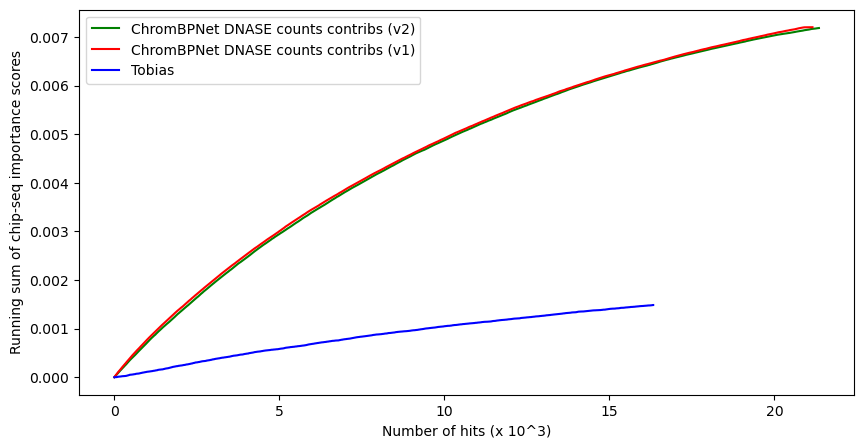

In [30]:
import matplotlib.pyplot as plt

# sort_col="cwm_scores"
# motif_hit_table_sorted = counts_atac.sort_values(sort_col, ascending=False)
# footprint_scores = motif_hit_table_sorted["footprint"]

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10, 5))

# ax.plot(
#     np.arange(len(footprint_scores)) / 1e3,
#     np.cumsum(footprint_scores) / 1e5,
#     label="ChromBPNet ATAC counts contribs", color="g"
# )


sort_col="hit_score"
motif_hit_table_sorted = counts_dnase_2.sort_values(sort_col, ascending=False)
footprint_scores = motif_hit_table_sorted["footprint"]


ax.plot(
    np.arange(len(footprint_scores)) / 1e3,
    np.cumsum(footprint_scores) / 1e5,
    label="ChromBPNet DNASE counts contribs (v2)", color="g"
)


sort_col="cwm_scores"
motif_hit_table_sorted = counts_dnase.sort_values(sort_col, ascending=False)
footprint_scores = motif_hit_table_sorted["footprint"]


ax.plot(
    np.arange(len(footprint_scores)) / 1e3,
    np.cumsum(footprint_scores) / 1e5,
    label="ChromBPNet DNASE counts contribs (v1)", color="r"
)

# sort_col="counts"
# motif_hit_table_sorted = counts_atac.sort_values(sort_col, ascending=False)
# footprint_scores = motif_hit_table_sorted["footprint"]


# ax.plot(
#     np.arange(len(footprint_scores)) / 1e3,
#     np.cumsum(footprint_scores) / 1e5,
#     label="Observed ATAC counts", color="g", linestyle="--",
# )

# sort_col="counts"
# motif_hit_table_sorted = counts_dnase.sort_values(sort_col, ascending=False)
# footprint_scores = motif_hit_table_sorted["footprint"]


# ax.plot(
#     np.arange(len(footprint_scores)) / 1e3,
#     np.cumsum(footprint_scores) / 1e5,
#     label="Observed DNASE counts", color="r", linestyle="--",
# )


sort_col="imp_frac_score"
motif_hit_table_sorted_tobias = tobias_atac.sort_values(sort_col, ascending=False)
footprint_scores_tobias = motif_hit_table_sorted_tobias["footprint"]

ax.plot(
    np.arange(len(footprint_scores_tobias)) / 1e3,
    np.cumsum(footprint_scores_tobias) / 1e5,
    label="Tobias", color="b"
)

plt.legend()

plt.ylabel("Running sum of chip-seq importance scores")
plt.xlabel("Number of hits (x 10^3)")
#plt.savefig(os.path.join(output_dir,output_path),format='pdf',)